# タイタニックの生存予測

kaggleで有名な[タイタニックの生存データ](https://www.kaggle.com/c/titanic)にて、EDA・モデル作成・評価を行う。

![kaggle](https://storage.googleapis.com/kaggle-media/welcome/screen1.png)

タイタニックのカラムの意味は以下。

- pclass： 旅客クラス（等級）
- name： 乗客の名前
- sex： 性別
    - male: 男性
    - female: 女性
- age： 年齢
- sibsp： タイタニック号に同乗している兄弟や配偶者の数
- parch： タイタニック号に同乗している親や子供の数
- ticket： チケット番号
- fare： 旅客運賃
- cabin： 客室番号
- embarked： 出港地
    - C: Cherbourg：シェルブール
    - Q: Queenstown：クイーンズタウン
    - S: Southampton：サウサンプトン
- boat： 救命ボート番号
- body： 遺体収容時の識別番号
- home.dest： 自宅または目的地
- survived：生存状況
    - 0: 死亡
    - 1: 生存

# 準備

## パッケージの読み込み・インストール

In [1]:
!pip install seaborn lightgbm

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/abeja/platform-public/pypi/simple


In [2]:
import csv
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from abeja.datalake import Client as DatalakeClient
%matplotlib inline

sns.set_style("darkgrid")

## データの読み込み

In [3]:
DATALAKE_CHANNEL_ID = '2412575017107'
TRAIN_DATALAKE_FILE_ID = '20210516T143337-15a92bf2-ecfc-4a40-9c4e-67a7cff783ed'
TEST_DATALAKE_FILE_ID = '20210516T143337-12766e06-8284-4e31-8de8-6da988820e28'

In [4]:
datalake_client = DatalakeClient()
channel = datalake_client.get_channel(DATALAKE_CHANNEL_ID)
train_file = channel.get_file(TRAIN_DATALAKE_FILE_ID)
test_file = channel.get_file(TEST_DATALAKE_FILE_ID)

In [5]:
train_df = pd.read_csv(train_file.download_uri)
test_df = pd.read_csv(test_file.download_uri)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# EDA

## データの全体像を使む

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- trainは800件、testは400件程度で少なめのデータ
- カラム数は目的変数である`Survived`を除くと10個
- objectタイプ（文字列など）のカラムがあるため、データの前処理が必要そう（後で詳しく見ていく

## 欠損値の確認

In [8]:
pd.concat([
    train_df.drop("Survived", axis=1).isna().mean(),
    test_df.isna().mean()
], axis=1).rename(columns={0: "train", 1: "test"})

,train,test
PassengerId,0.000000,0.000000
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,0.198653,0.205742
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.002392
Cabin,0.771044,0.782297


- CabinとAgeが主に欠損している
- Embarkedはtrainのみ少量だが欠損しているのに注意

## 各カラムのデータを確認

- カラムのサンプルデータと分布や最頻値などをまとめて確認
- 各カラムがどういうデータであるかをまず確認する目的
- 数値や文字列などで分布の出し方は場合分け

In [9]:
def check_column(df, column):
    print("\n" + "="*30)
    print(f"Column: {column}")
    print("="*30)
    print("-"*8 + "5sample" + "-"*8)
    srs = df[column]
    
    # head
    display(srs.head())
    
    # unique num
    nunique = srs.nunique()

    print("-"*20)
    col_type = srs.dtype
    if col_type == "object":
        # string data
        print(srs.value_counts(dropna=False))
    else:
        # numerical data
        if nunique < 10:
            srs.value_counts().sort_index().plot.bar()
            plt.show()
        else:
            srs.hist(bins=30).plot()
            plt.show()


Column: PassengerId
--------5sample--------


0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

--------------------


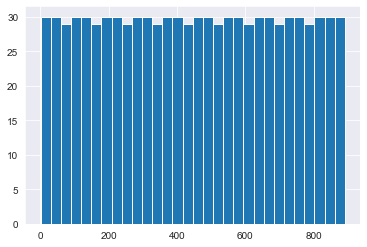


Column: Survived
--------5sample--------


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

--------------------


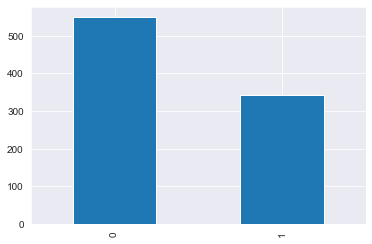


Column: Pclass
--------5sample--------


0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

--------------------


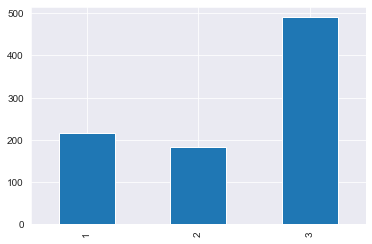


Column: Name
--------5sample--------


0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

--------------------
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

Column: Sex
--------5sample--------


0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

--------------------
male      577
female    314
Name: Sex, dtype: int64

Column: Age
--------5sample--------


0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

--------------------


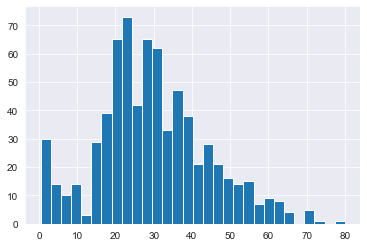


Column: SibSp
--------5sample--------


0    1
1    1
2    0
3    1
4    0
Name: SibSp, dtype: int64

--------------------


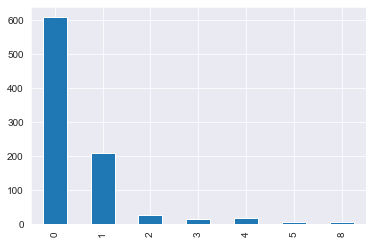


Column: Parch
--------5sample--------


0    0
1    0
2    0
3    0
4    0
Name: Parch, dtype: int64

--------------------


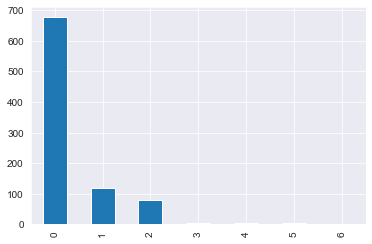


Column: Ticket
--------5sample--------


0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

--------------------
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Column: Fare
--------5sample--------


0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

--------------------


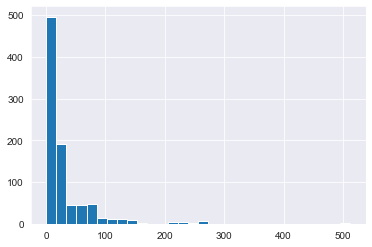


Column: Cabin
--------5sample--------


0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

--------------------
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

Column: Embarked
--------5sample--------


0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

--------------------
S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64


In [10]:
for col in train_df.columns:
    check_column(train_df, col)

- PassengerId
  - 連番のユニークIDと思って間違いない
- Survived(目的変数)
  - 少し不均衡で1が少ないが極端ではない
- Pclass
  - 3クラス目あって、3つ目の人が多い
- Name
  - 名前がそのまま入っている。テキスト処理が必要そう
- Sex
  - 男女どちらか
  - 男性の方が多い
- Age
  - 一般的な年齢分布に近い
  - 不明データが-1になっている等、明らかに変なデータはなさそう
- SibSp
  - ほとんどが0人、時々1人、それ以上はまれに存在
- Parch
  - ほとんどが0人、1人以上は時々
- Ticket
  - 文字列と数値が含まれている
  - どういう規則性があるのかを見たほうが良さそう
- Fare
  - 小数点以下まで存在
  - 値のばらつきが大きい
- Cabin
  - 複数の値が半角スペースで区切られている
  - テキスト処理が必要そう
- Embarked
  - ほとんどが３つのどれか
  - テキストなので、何らか数値にする処理が必要

## 各カラムの目的変数の関係性

In [11]:
feature_cols = [c for c in train_df.columns if c not in ["PassengerId", "Survived"]]
feature_cols

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

比較しやすいカラムだけまず見る

### Pclass

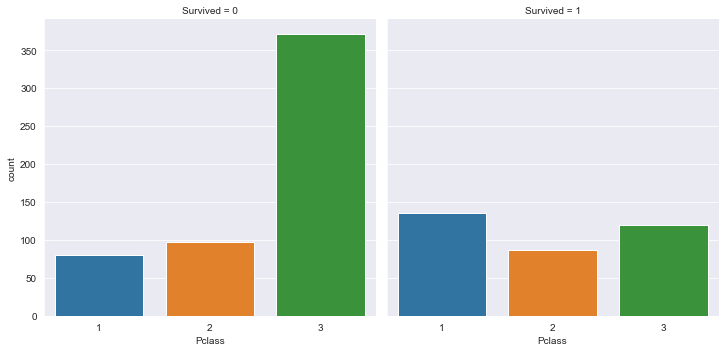

In [12]:
col = "Pclass"
sns.catplot(x=col, col="Survived", kind='count', data=train_df)

Pclassが小さいほど生存率がかなり上がっている

### Sex

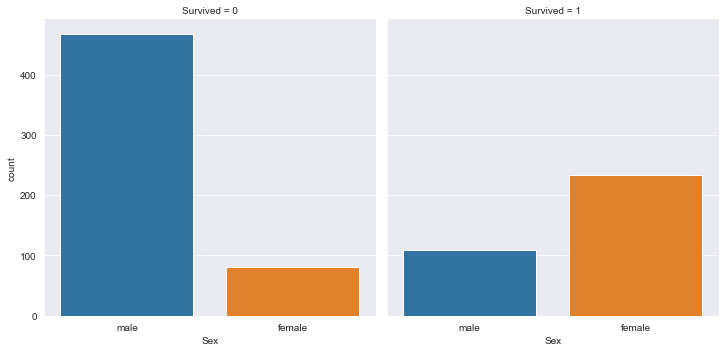

In [13]:
col = "Sex"
sns.catplot(x=col, col="Survived", kind='count', data=train_df)

- 女性の方が生存率がたかい

### SibSp

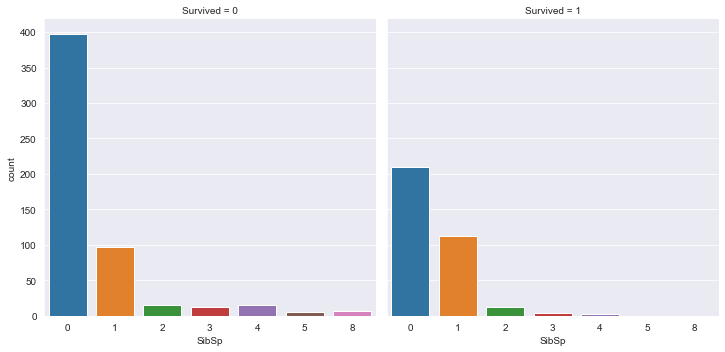

In [14]:
col = "SibSp"
sns.catplot(x=col, col="Survived", kind='count', data=train_df)

値が大きい人ほど生存率がたかい

### Parch

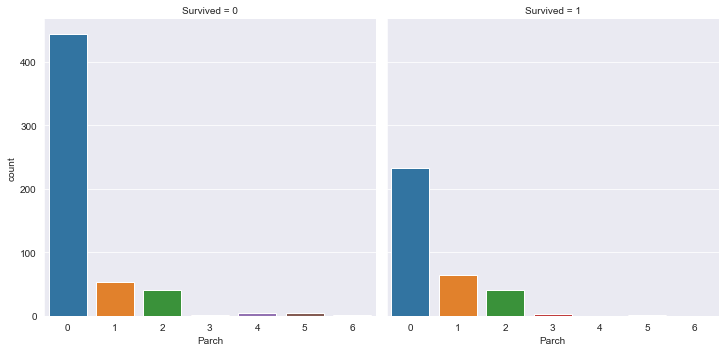

In [15]:
col = "Parch"
sns.catplot(x=col, col="Survived", kind='count', data=train_df)

SibSp同様に値が大きい人ほど生存率がたかい

### Embarked

In [16]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

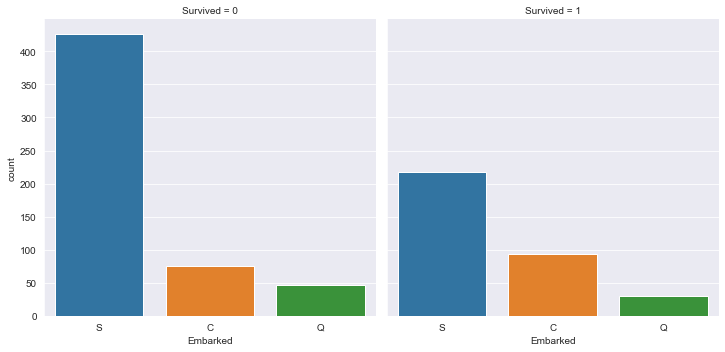

In [17]:
col = "Embarked"
sns.catplot(x=col, col="Survived", kind='count', data=train_df)

### Age

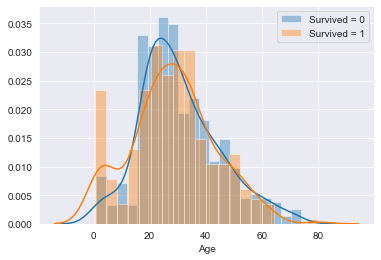

In [18]:
col = "Age"
sns.distplot(train_df.loc[train_df["Survived"] == 0, col], kde=True, bins=20, label="Survived = 0")
sns.distplot(train_df.loc[train_df["Survived"] == 1, col], kde=True, bins=20, label="Survived = 1")
plt.legend()

未成年の生存率が高い傾向がある

### Fare

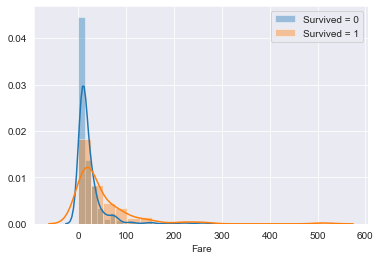

In [19]:
col = "Fare"
sns.distplot(train_df.loc[train_df["Survived"] == 0, col], kde=True, bins=20, label="Survived = 0")
sns.distplot(train_df.loc[train_df["Survived"] == 1, col], kde=True, bins=20, label="Survived = 1")
plt.legend()

## テキストが含まれるデータの分析

### Ticket

In [20]:
train_df["Ticket"].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [21]:
def is_int(s):
    try:
        val = int(s)
        return True
    except:
        return False

#### 文字列が含まれる（数値変換できない）データを確認

In [22]:
cond_int_ticket = train_df["Ticket"].map(is_int)
print(f"文字列が含まれる割合: {(~cond_int_ticket).mean():.5f}")
display(train_df.loc[~cond_int_ticket, "Ticket"].value_counts())

文字列が含まれる割合: 0.25814


CA. 2343              7
CA 2144               6
S.O.C. 14879          5
PC 17757              4
LINE                  4
                     ..
F.C.C. 13528          1
SOTON/O.Q. 3101311    1
A/5 3540              1
PC 17610              1
SOTON/OQ 392076       1
Name: Ticket, Length: 167, dtype: int64

「文字列 + 半角スペース + 数値」のパターンが多そう？

#### 半角スペースで区切って最初の英数字を抽出

In [23]:
train_df.loc[~cond_int_ticket, "Ticket"].map(lambda x: x.split()[0]).value_counts()

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
A/5.           7
SOTON/OQ       7
STON/O2.       6
CA             6
F.C.C.         5
C              5
SC/PARIS       5
S.O.C.         5
SC/Paris       4
LINE           4
A/4            3
PP             3
A/4.           3
S.O./P.P.      3
SC/AH          3
A.5.           2
A./5.          2
P/PP           2
WE/P           2
SOTON/O2       2
S.C./PARIS     2
S.W./PP        1
F.C.           1
A/S            1
SO/C           1
W/C            1
SC             1
SCO/W          1
SW/PP          1
Fa             1
S.O.P.         1
S.C./A.4.      1
A4.            1
S.P.           1
W.E.P.         1
C.A./SOTON     1
Name: Ticket, dtype: int64

- いくつかのパターンが存在
- "C.A."や"CA."、"CA"などは同じ可能性がある。名寄せしたほうがいいかもしれない
- 数値部分と文字列部分に分けて特徴量を作ると良いかもしれない

#### 文字列を半角スペースで区切った２つ目のパートが全て数値なのか、文字列が含まれるかを確認

In [24]:
train_df.loc[~cond_int_ticket, "Ticket"].map(
    lambda x: x.split()[1] if len(x.split()) > 1 and not is_int(x.split()[1]) else np.nan
).value_counts()

2.       12
Basle     1
Name: Ticket, dtype: int64

- Basleというものだけ例外そう
- "2."は"."を除けば良さそう

#### 数字について重複はある？（ユニークな数字なのかどうか）

In [25]:
train_df[cond_int_ticket]["Ticket"].value_counts()

1601       7
347082     7
3101295    6
347088     6
382652     5
          ..
3101267    1
11765      1
14313      1
2626       1
370376     1
Name: Ticket, Length: 514, dtype: int64

ところどころ重複は見られる

#### 数字の連番を確認

In [26]:
train_df.sort_values("Ticket").iloc[:30][["Ticket", "Cabin", "Fare", "Name"]]

,Ticket,Cabin,Fare,Name
504,110152,B79,86.5000,"Maioni, Miss. Roberta"
257,110152,B77,86.5000,"Cherry, Miss. Gladys"
759,110152,B77,86.5000,"Rothes, the Countess. of (Lucy Noel Martha Dye..."
262,110413,E67,79.6500,"Taussig, Mr. Emil"
558,110413,E67,79.6500,"Taussig, Mrs. Emil (Tillie Mandelbaum)"
585,110413,E68,79.6500,"Taussig, Miss. Ruth"
110,110465,C110,52.0000,"Porter, Mr. Walter Chamberlain"
475,110465,A14,52.0000,"Clifford, Mr. George Quincy"
430,110564,C52,26.5500,"Bjornstrom-Steffansson, Mr. Mauritz Hakan"
366,110813,D37,75.2500,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)"


- Ticketが同じものや連番のケースは、同一料金だったり、名前的に同じ家族のヒトのケースが見受けられる
- Ticketの発行の方法によって、同一のTicket番号になることもあれば、連番になることもあるのかもしれない

#### 同一チケット内の料金を確認

In [27]:
ticket_fare_nunique = train_df.groupby("Ticket")["Fare"].nunique()
ticket_fare_nunique.value_counts()

1    680
2      1
Name: Fare, dtype: int64

In [28]:
ticket_fare_nunique[ticket_fare_nunique > 1]

Ticket
7534    2
Name: Fare, dtype: int64

In [29]:
train_df.query("Ticket == '7534'")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S


ほとんどのケース(7534を除く)で一つのチケットは同一料金である

### Cabin

#### 同一Cabinのデータがどれくらいあるか？

In [30]:
train_df[~train_df["Cabin"].isna()]["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

せいぜい4つ程度

#### 半角スペースで区切ってみる

In [31]:
trn_cabin_splits = train_df["Cabin"].map(lambda x: x.split() if x == x else [])

#### 区切ったときに何個のデータが１レコードあたりにあるか？

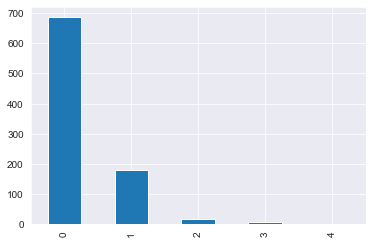

In [32]:
trn_cabin_splits.map(len).value_counts().sort_index().plot.bar();

- 0は元から欠損のもの
-ほとんどが1つで2, 3 ,4 のものもところどころある

In [33]:
trn_cabin_len = trn_cabin_splits.map(len)
for i in range(5):
    print(i, train_df.loc[trn_cabin_len == i, "Survived"].mean())

0 0.29985443959243085
1 0.6777777777777778
2 0.5625
3 0.5
4 1.0


欠損しているよりはCABINの情報が入っている方が、生存率が高い（2~4は母数が少ないため判断が難しい）

#### Cabinのアルファベットについて

C85というようにアルファベット+数字でCABIN名がついている。このCのような数字を確認する

#### アルファベットの数は１レコード辺り１つだけか？

In [34]:
trn_cabin_splits.map(lambda x_list: list(set([x[0] for x in x_list]))).map(len).value_counts()

0    687
1    200
2      4
Name: Cabin, dtype: int64

2つアルファベットがあるレコードも存在する

#### アルファベットのパターン列挙

In [35]:
trn_cabin_alphabets = sorted(
    list(set(itertools.chain.from_iterable(trn_cabin_splits.map(lambda x_list: list(set([x[0] for x in x_list]))).tolist())))
)
trn_cabin_alphabets

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

#### ２文字目もアルファベットのものがないかを確認

In [36]:
trn_cabin_second_char = sorted(
    list(set(itertools.chain.from_iterable(trn_cabin_splits.map(lambda x_list: list(set([x[1] for x in x_list if len(x) > 1]))).tolist())))
)
trn_cabin_second_char

['1', '2', '3', '4', '5', '6', '7', '8', '9']

２文字目は数字のみらしい

#### アルファベット毎の生存率を確認

In [37]:
char_results = {}
char_counts = {}
for char in trn_cabin_alphabets:
    char_cond = train_df["Cabin"].fillna("").str.contains(char)
    char_target_ratio = train_df.loc[char_cond, "Survived"].mean()
    char_results[char] = char_target_ratio
    char_counts[char] = char_cond.sum()

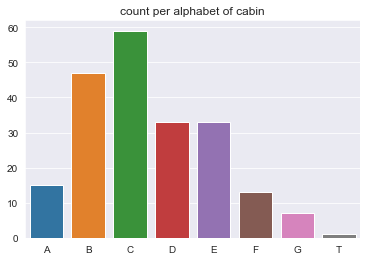

In [38]:
sns.barplot(x=list(char_counts.keys()), y=list(char_counts.values()))
plt.title("count per alphabet of cabin")
plt.show()

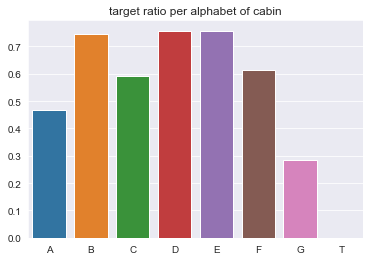

In [39]:
sns.barplot(x=list(char_results.keys()), y=list(char_results.values()))
plt.title("target ratio per alphabet of cabin")
plt.show()

- アルファベット毎に多少は差がある
- 特徴量には入れたほうが良い気がする

- EmbarkedがSのヒトは生存率が低い、逆にCは高め

### Name

#### 重複した名前は存在する?

In [40]:
train_df["Name"].value_counts().iloc[:5]

Braund, Mr. Owen Harris             1
Boulos, Mr. Hanna                   1
Frolicher-Stehli, Mr. Maxmillian    1
Gilinski, Mr. Eliezer               1
Murdlin, Mr. Joseph                 1
Name: Name, dtype: int64

名前の重複はなさそう

## モデル作成

### 特徴量作成

In [41]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [42]:
def make_feature(train_df, test_df):
    
    # カウントエンコーディング
    # TicketとCabinは同じものは少ないが、重複したものもあるため含める
    count_encode_cols = [
        "Sex",
        "Embarked",
        "Ticket",
        "Cabin"
    ]
    for col in count_encode_cols:
        ce_col = f"count_{col}"
        trn_count = train_df[col].value_counts()
        train_df[ce_col] = train_df[col].map(trn_count)
        test_df[ce_col] = test_df[col].map(trn_count)
        
    
    # Cabinの頭文字をone-hot encodingで特徴量化
    trn_cabin_splits = train_df["Cabin"].map(lambda x: x.split() if x == x else [])
    tst_cabin_splits = test_df["Cabin"].map(lambda x: x.split() if x == x else [])
    encoder = MultiLabelBinarizer()
    trn_cabin_arr = encoder.fit_transform(trn_cabin_splits.map(
        lambda x_list: list(set([x[0] for x in x_list]))).tolist()
    )
    tst_cabin_arr = encoder.transform(tst_cabin_splits.map(
        lambda x_list: list(set([x[0] for x in x_list]))).tolist()
    )
    trn_cabin_char_df = pd.DataFrame(trn_cabin_arr, columns=encoder.classes_)
    tst_cabin_char_df = pd.DataFrame(tst_cabin_arr, columns=encoder.classes_)
    
    train_df = pd.concat([train_df, trn_cabin_char_df], axis=1)
    test_df = pd.concat([test_df, tst_cabin_char_df], axis=1)

    
    # Ticketの前半部分の文字列
    # 前処理でドットの記号も外す
    # count encodingする
    def preprocess_ticket_char(s):
        s = s.replace(".", "")
        return s

    trn_ticket_front_char = train_df["Ticket"].map(
        lambda x: preprocess_ticket_char(x.split()[0]) if x == x else np.nan
    )
    tst_ticket_front_char = test_df["Ticket"].map(
        lambda x: preprocess_ticket_char(x.split()[0]) if x == x else np.nan
    )
    trn_count = trn_ticket_front_char.value_counts()
    train_df["count_ticket_front_char"] = trn_ticket_front_char.map(trn_count)
    test_df["count_ticket_front_char"] = tst_ticket_front_char.map(trn_count)



    def make_handcraft_feature(df):
        """その他データを見た上での特徴量
        trainとtestそれぞれこの関数を通す
        """
        # 家族の総数
        df["total_family_num"] = df["SibSp"] + df["Parch"]
        # 家族総数のなかでSibSpの割合
        df["SibSp_ratio_in_total_family"] = df["SibSp"] / (1 + df["total_family_num"])
        
        # Cabinがいくつあるか？
        df["Cabin_num"] = df["Cabin"].map(lambda x: len(x.split()) if x == x else 0)
        return df
    
    train_df = make_handcraft_feature(train_df)
    test_df = make_handcraft_feature(test_df)
    
    return train_df, test_df

In [43]:
train_df, test_df = make_feature(train_df, test_df)

### モデルの学習

- 勾配ブースティングのモデルであるLightGBMを利用
- モデル選定理由
  - 精度が高い
  - 欠損値の処理やスケールの前処理が不要
  - 学習速度が早い

In [44]:
def train(train_df, test_df, target_col="Survived", cat_cols=[]):
    
    #######################
    # HyperParameter
    #######################
    lgb_params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting": "gbdt",
        'learning_rate': 0.05,
        'num_leaves': 128,
        'min_data_in_leaf': 10,
        'max_depth': 4,
        "bagging_freq": 1,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.7,
        "lambda_l1": 0.3,
        "lambda_l2": 0.8,
        "seed": 42,
        "num_threads": -1,
    }

    #######################
    # Feature
    #######################
    except_cols = [
        "PassengerId",
        "Survived",
        "Name",
        "Sex",
        "Ticket",
        "Cabin"
    ]
    str_cols = [c for c in train_df.columns if train_df[c].dtype == "object"]
    print(str_cols)
    except_cols += str_cols

    use_feats = [
        c for c in train_df.columns if c not in except_cols]
    use_feats = sorted(use_feats)

    target_col = "Survived"
    oof_preds = np.zeros(len(train_df))

    model_list = []
    importance_list = []
    val_score_list = []

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_ix, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[target_col])):

        print(f"Fold {fold_ix}")
        _train_df = train_df.iloc[trn_idx].reset_index(drop=True)
        _valid_df = train_df.iloc[val_idx].reset_index(drop=True)

        train_X = _train_df[use_feats]
        train_y = _train_df[target_col]

        valid_X = _valid_df[use_feats]
        valid_y = _valid_df[target_col]

        trn_dataset = lgb.Dataset(
            train_X,
            label=train_y
        )
        val_dataset = lgb.Dataset(
            valid_X,
            label=valid_y
        )            

        print(f"Train shape {train_X.shape}")
        model = lgb.train(
                    lgb_params,
                    trn_dataset,
                    10000,
                    valid_sets = [trn_dataset, val_dataset],
                    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
        )
        imp_df = pd.DataFrame()
        imp_df['feature'] = use_feats
        imp_df['gain'] = model.feature_importance(importance_type="gain")
        importance_list.append(imp_df)
        oof_preds[val_idx] = model.predict(valid_X)
        model_list.append(model)

        # calc oof score
        val_score = roc_auc_score(valid_y, oof_preds[val_idx])
        val_score_list.append(val_score)
        print(f"Fold Valid Score: {val_score}")
    
    importance_df = pd.concat(importance_list).groupby("feature")["gain"].mean().reset_index()
    importance_df = importance_df.sort_values("gain", ascending=False).reset_index(drop=True)
    total_val_score = roc_auc_score(train_df[target_col], oof_preds)

    print("="*30)
    print(f"Fold Valid Score(roc auc): {total_val_score}")
   
    return total_val_score, importance_df, oof_preds

In [45]:
total_val_score, importance_df, oof_preds = train(train_df, test_df)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Fold 0
Train shape (712, 21)
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.333285	valid_1's binary_logloss: 0.371025
[200]	training's binary_logloss: 0.279047	valid_1's binary_logloss: 0.357604
[300]	training's binary_logloss: 0.241981	valid_1's binary_logloss: 0.35038
[400]	training's binary_logloss: 0.215319	valid_1's binary_logloss: 0.350935
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.227804	valid_1's binary_logloss: 0.348305
Fold Valid Score: 0.9193675889328062
Fold 1
Train shape (713, 21)
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.325121	valid_1's binary_logloss: 0.382748
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.293224	valid_1's binary_logloss: 0.379753
Fold Valid Score: 0.8931818181818183
Fold 2
Train shape (713, 21)
Training until validation scores don't improve for 50 rounds
[

- CrossValidationのROC-AUCで0.88

### ROC曲線

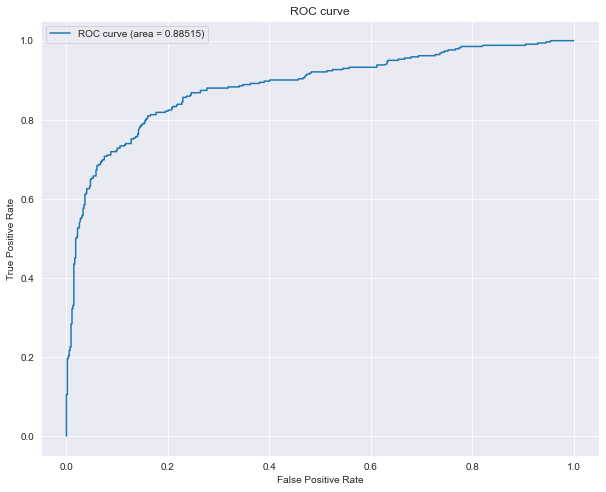

In [46]:
# ROC曲線をプロット   
fpr_fe, tpr_fe, thresholds_fe = roc_curve(train_df["Survived"], oof_preds)
plt.figure(figsize=(10, 8))
plt.plot(fpr_fe, tpr_fe, label=f"ROC curve (area = {total_val_score:.5f})")
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## Confusion Matrixを確認する

In [47]:
# 予測スコアが0.5以上のものを1, それ以外を0とする
pred_binary = np.where(oof_preds > 0.5, 1, 0)

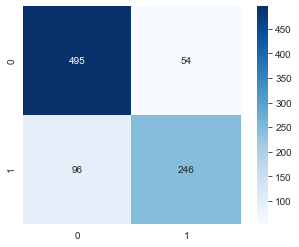

In [48]:
cm = confusion_matrix(train_df["Survived"], pred_binary).astype(int)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt=".5g")
plt.show()

## 特徴量重要度

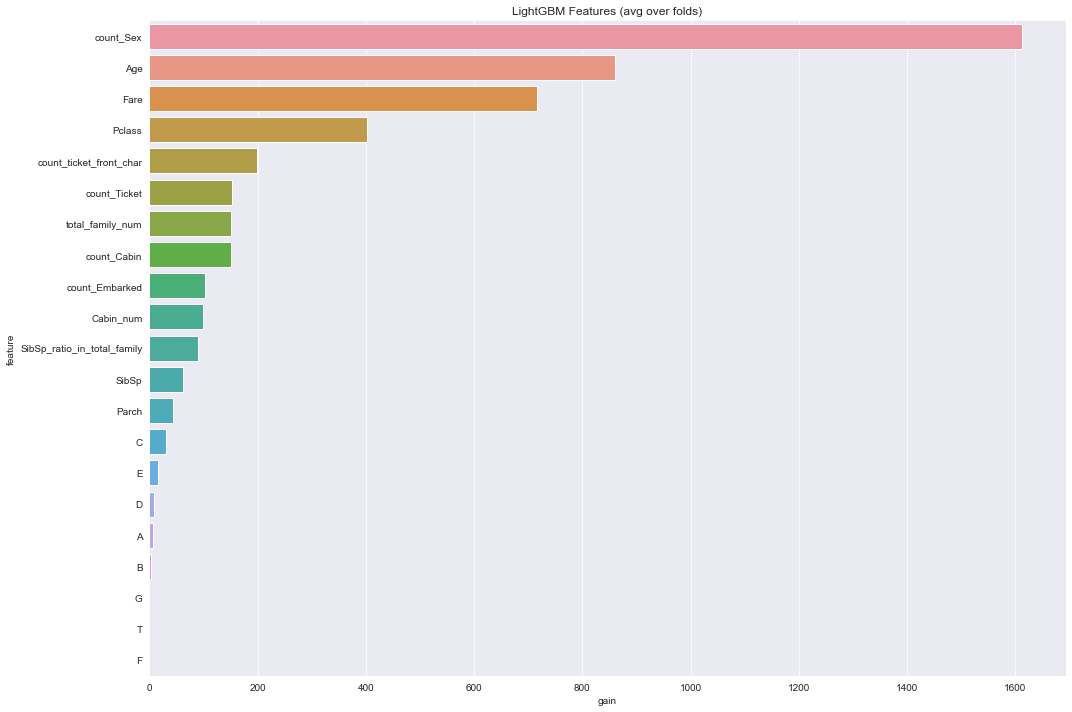

In [49]:
plt.figure(figsize=(15, 10))
sns.barplot(x="gain", y="feature", data=importance_df)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

- 性別・年齢・運賃が特に重要な特徴量と判断している
- Ticketの最初の文字に関する特徴量も上位に来ている
  - この辺りの特徴量を増やすともう少し精度が上がるかもしれない